In [1]:
import sys
sys.path.append("..")
from MPRA_predict.utils import *
from MPRA_predict.datasets import *
from MPRA_predict.metrics import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 3)
np.set_printoptions(linewidth=1000)

In [2]:
MPRA_df = pd.read_csv('../data/SirajMPRA/SirajMPRA_562654.csv')
MPRA_df

,description,seq,A549,HepG2,K562,SK-N-SH,HCT116,is_ref,chr,pos,ref,alt,start,end,585605_index
0,chr1:14677:G:A,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,NaN,0.668,-0.704,0.539,0.159,True,chr1,14677,G,A,14577,14777,0
1,chr1:14677:G:A,AGTGCTGGTTCCGTCACCCCCTCCCAAGGAAGTAGGTCTGAGCAGC...,NaN,0.416,0.554,0.442,-0.288,False,chr1,14677,G,A,14577,14777,1
2,chr1:63697:T:C,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,NaN,1.270,-0.391,0.752,1.100,True,chr1,63697,T,C,63597,63797,2
3,chr1:63697:T:C,CATACATTTTTATTCTGGTCACTGTCCAACGACATTCCTCAAATGA...,NaN,1.152,-0.659,0.205,1.051,False,chr1,63697,T,C,63597,63797,3
4,chr1:64764:C:T,AATAGACTCTAGTACTCTGTATTATGCAAAATTTGTCTATGTTACA...,NaN,-0.211,-0.007,0.499,0.258,True,chr1,64764,C,T,64664,64864,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562649,chrX:155233098:T:C,ATCATTTACTGGTGACTGCCCTGCTAGGGTGTCAGCTGTCAGATCC...,NaN,0.616,1.927,0.798,1.035,False,chrX,155233098,T,C,155232998,155233198,585600
562650,chrX:155233794:A:G,TGGTTACTGCAGGGGCAGGGTTTTGGCAGGAAATAAACATGCACGG...,NaN,1.410,0.556,2.843,1.496,True,chrX,155233794,A,G,155233694,155233894,585601
562651,chrX:155233794:A:G,TGGTTACTGCAGGGGCAGGGTTTTGGCAGGAAATAAACATGCACGG...,NaN,0.895,-0.073,1.974,0.795,False,chrX,155233794,A,G,155233694,155233894,585602
562652,chrX:155234730:T:C,TGGTGAGTTGCTTCTGTGCACACACTTTTGTTTATGAGTGTGCATG...,NaN,0.312,0.166,-0.041,0.444,True,chrX,155234730,T,C,155234630,155234830,585603


In [5]:
feature_matrix = np.load('Sei_Siraj_feature_matrix.npy')
feature_matrix.shape

(562654, 5, 8)

In [6]:
cell_types = ['HepG2', 'K562', 'SK-N-SH', 'A549', 'HCT116']
assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3', 'CTCF']

data_split_dict = {}
data_split_dict['total'] = np.ones(len(MPRA_df), dtype=bool)
data_split_dict['chrom'] = MPRA_df['chr'].isin([f'chr{i}' for i in range(1, 23)])
data_split_dict['train'] = MPRA_df['chr'].isin([f'chr{i}' for i in range(3, 23)])
data_split_dict['valid'] = MPRA_df['chr'].isin(['chr1'])
data_split_dict['test'] = MPRA_df['chr'].isin(['chr2'])
data_split_dict['designed'] = MPRA_df['chr'].isin(['chr0'])

data_split_dict['ref'] = MPRA_df['is_ref']
data_split_dict['alt'] = ~MPRA_df['is_ref']

# stds = MPRA_df[cell_types].std(axis=1, skipna=True)
# threshold = np.percentile(stds.dropna(), 90)
# data_split_dict['diff'] = (stds > threshold)
# data_split_dict['const'] = ~data_split_dict['diff']

# main_df['diff'] = (main_df[cell_types].max(axis=1) - main_df[cell_types].min(axis=1)) > 1
# data_split_dict['const'] = ~main_df['diff']
# data_split_dict['diff']  = main_df['diff']

# keys = list(data_split_dict.keys())
# for k1 in keys:
#     for k2 in keys:
#         data_split_dict[f'{k1}_{k2}'] = data_split_dict[k1] & data_split_dict[k2]

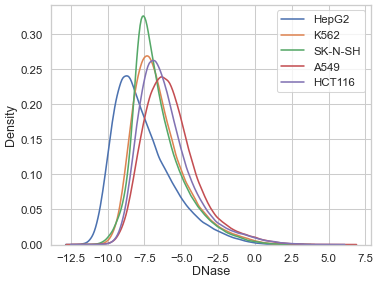

/tmp/ipykernel_64469/113565512.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


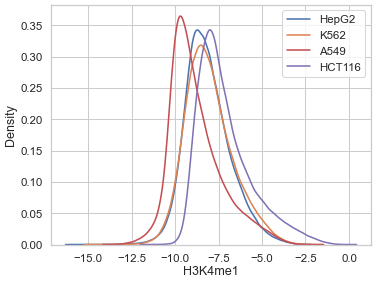

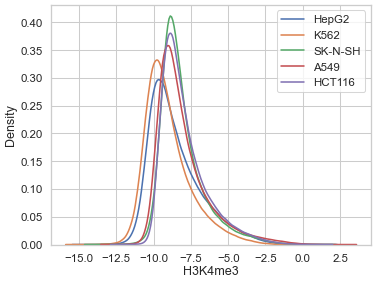

/tmp/ipykernel_64469/113565512.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


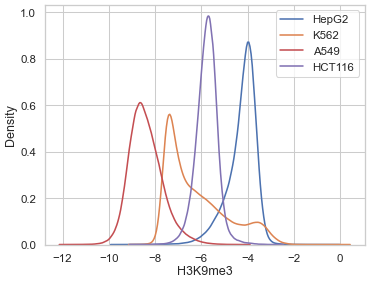

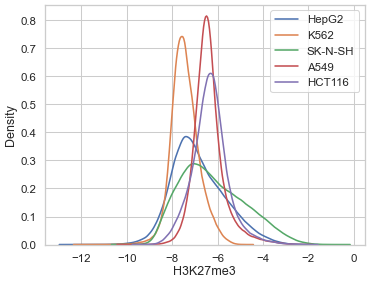

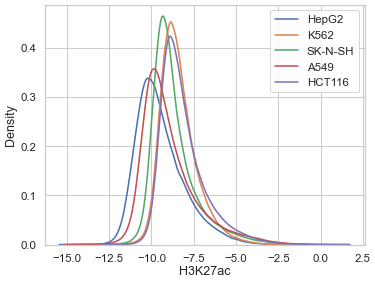

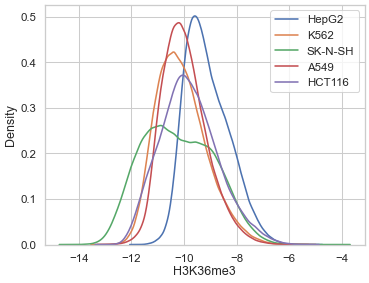

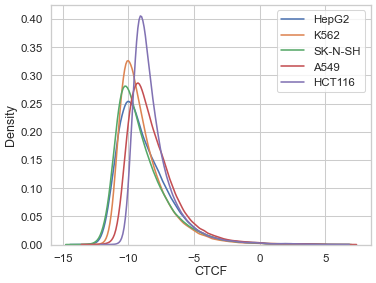

In [7]:
for j, assay in enumerate(assays):
    plt.figure(figsize=(8, 6), dpi=50)
    plt.subplots_adjust(left=0.13, bottom=0.15, right=0.93, top=0.95)
    for i, cell_type in enumerate(cell_types):
        x = feature_matrix[:, i, j]
        sns.kdeplot(x, label=cell_type)
    plt.xlabel(f'{assay}')
    plt.legend()
    plt.show()

In [8]:
# normalize between different cell types

feature_matrix_norm = np.full_like(feature_matrix, np.nan)

for i, cell_type in enumerate(cell_types):
    for j, assay in enumerate(assays):
        x = feature_matrix[:, i, j]
        condition = data_split_dict['train']
        x_mean = np.mean(x[condition])
        x_std = np.std(x[condition])
        x = (x - x_mean) / x_std
        feature_matrix_norm[:, i, j] = x

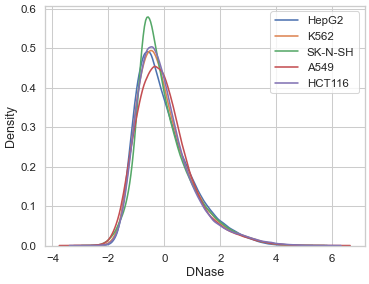

/tmp/ipykernel_64469/2171355260.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


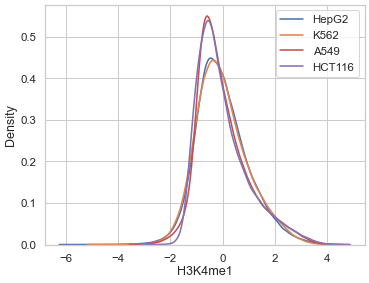

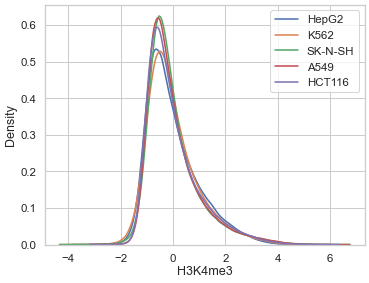

/tmp/ipykernel_64469/2171355260.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


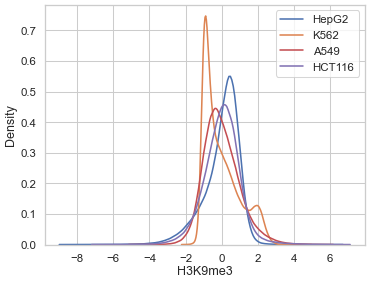

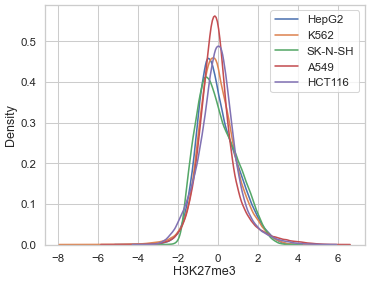

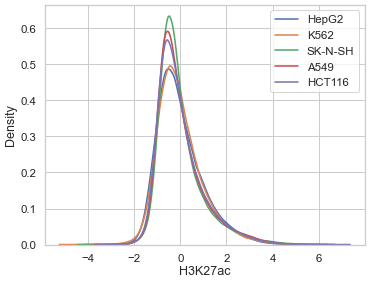

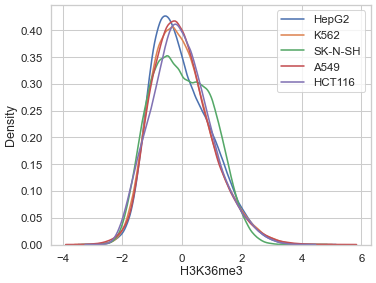

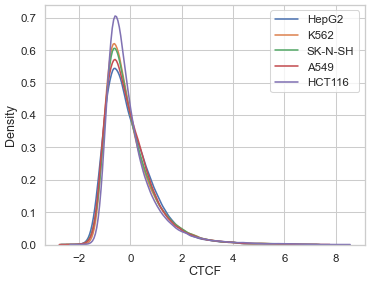

In [9]:
for j, assay in enumerate(assays):
    plt.figure(figsize=(8, 6), dpi=50)
    plt.subplots_adjust(left=0.13, bottom=0.15, right=0.93, top=0.95)
    for i, cell_type in enumerate(cell_types):
        x = feature_matrix_norm[:, i, j]
        sns.kdeplot(x, label=cell_type)
    plt.xlabel(f'{assay}')
    plt.legend()
    plt.show()

In [11]:
np.save('Sei_Siraj_feature_matrix_norm.npy', feature_matrix_norm)